# GMMs A La VAE

In class we discussed how GMMs have largely the same type of generative procedure as VAEs: generate a latent "code" Z (cluster id for GMMs), and generate the input features given the code (using a lookup operation for the mean and covariance of X|Z). Here we shall optimize the parameters of GMMs not using likelihoods directly, nor using EM. Instead, here we shall optimize the parameters of a GMM using a variational lower bound (ELBO with an approximate posterior).

**Turn in by December 1st 11:59PM via https://docs.google.com/forms/d/e/1FAIpQLSdsNo42vSPpLr1n7aglO6qUHXwNeaZDWLycKssOUuqmRj-7_g/viewform?usp=pp_url.**


## Data and Setup

First, it may help to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, confirm that we can connect to the GPU with tensorflow.

*(Note, it is fine if you can not connect to GPU, it just might take a little longer to run.)*

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

Let's import additional packages of use.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

Next, we prescribe the ground truth parameters to generate data.
Recall that the parameters are $\pi_j$, the mixing prior coefficients for components, $\mu_j$, the means for components, and $\sigma_j$ the standard deviation for components. $\pi$ will be represented with logits in `gt_logits`; i.e. the softmax of `gt_logits` is $\pi$. $\mu$ is represented by `gt_means`. $\sigma$ is represented in log space by `gt_lsigmas`; i.e. the exp of `gt_lsigmas` is $\sigma$.




In [ ]:
gt_logits = tf.math.log([1/4, 1/4, 1/6, 1/6, 1/6])
gt_means = tf.convert_to_tensor([1.0, -0.5, -2, .5, 3])
gt_lsigmas = tf.math.log([.5, 1.0, .2, 0.1, .5])

**Sample data based on the parameters**

In [ ]:
def make_data(N, logits, means, lsigmas):
  z = tf.transpose(tf.random.categorical([logits], N))
  y = tf.random.normal((N, 1))

  x = tf.gather(means, z)+tf.gather(tf.math.exp(lsigmas), z)*y
  return x

Now plot the data. (Hint: it should look something like this image.)

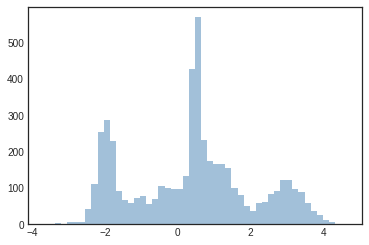

In [ ]:
NUM_EXAMPLES = 5000
training_inputs = make_data(NUM_EXAMPLES, gt_logits, gt_means, gt_lsigmas)
plt.hist(np.reshape(training_inputs, [-1]), bins=50, alpha=0.5,
         histtype='stepfilled', color='steelblue', edgecolor='none');

**Likelihood Helper Functions**


In [ ]:
def mixture_likelihood(x, logits, means, lsigmas):
    """Given log-unnormalized mixture weights, shift, and log scale parameters
    for mixture components, return the likelihoods for targets.
    Args:
        x: N x 1 tensor of 1d targets to get likelihoods for.
        logits: ncomp tensor of mixing priors of mixture model.
        means: ncomp tensor of means of mixture model.
        lsigmas: ncomp tensor of log std. dev. of mixture model.
    Return:
        likelihoods: N x 1  tensor of likelihoods log p(x).
    """
    # Compute likelihoods per x
    # Write log likelihood with logsumexp.
    sigmas = tf.expand_dims(tf.exp(lsigmas), 0)
    logits = tf.expand_dims(logits, 0)
    means = tf.expand_dims(means, 0)
    log_norm_consts = -lsigmas - 0.5*np.log(2.0*np.pi)
    log_kernel = -0.5*tf.square((x-means)/sigmas)
    log_exp_terms = log_kernel + log_norm_consts + logits
    log_likelihoods = tf.reduce_logsumexp(log_exp_terms, -1) - \
        tf.reduce_logsumexp(logits, -1)
    return log_likelihoods

In [ ]:
def plot_density(logits, means, lsigmas):
  gridx = np.reshape(np.linspace(-5.0, 5.0, 1000), [-1, 1])
  log_px = mixture_likelihood(gridx, logits, means, lsigmas)
  plt.plot(gridx, np.exp(log_px))
  plt.scatter(tf.reshape(means, [-1, 1]), np.exp(mixture_likelihood(tf.reshape(means, [-1, 1]), logits, means, lsigmas)))

## Variational GMMs (70 Points)

Now we will train a GMM using a variational bound. Similarly to VAEs, the approximate posterior (denoted as $q$ in class) will be parameterized as a neural network that yeilds $q(z_i \mid x_i)$. Unlike VAEs, we will not sample from $q(z_i \mid x_i)$ to approximate the ELBO; instead, we shall directly compute an expectation w.r.t. $q(z_i \mid x_i)$.


**KL Divergence (20 points)**

KL plays an important role in variational inference. Implement the function below to compute the KL divergence of multiple pairs of distributions. *Do not use an existing implementation of KL.*

In [ ]:
def kl_divergence(p_logits, q_logits):
  """ Compute the KL divergence between discrete distributions p and q.
  Args:
        p_logits: N x m tensor of logits for N distributions over m elements.
        q_logits: N x m  tensor of logits for N distributions over m elements.
    Return:
        kl: N tensor of KL(p_i || q_i)
  """
  """ Hint: it is numerically stable to use
    tf.nn.softmax_cross_entropy_with_logits. Be careful about what is in logit
    versus probability space.
  """
  Hq_P = tf.nn.softmax_cross_entropy_with_logits(labels = tf.exp(p_logits), logits = q_logits, axis = -1)
  H_P  = tf.nn.softmax_cross_entropy_with_logits(labels = tf.exp(p_logits), logits = p_logits, axis = -1)
  Dq_P = Hq_P - H_P
  return Dq_P  # TODO

**ELBO (20 points)**

Next we shall implement the ELBO for a model and given approximate posterior likelihoods.

In [ ]:
def mixture_posterior_logits(x, logits, means, lsigmas):
  """Given log-unnormalized mixture weights, shift, and log scale parameters
  for mixture components, return the posterior of latent z_i's.
  Args:
      x: N x 1 tensor of 1d targets to get posteriors for.
      logits: ncomp tensor of mixing priors of mixture model
      means: ncomp tensor of means of mixture model.
      lsigmas: ncomp tensor of log std. dev. of mixture model.
  Return:
      posterior_logits: N x ncomp  tensor logits for posterior of z_i's.
  """
  sigmas = tf.expand_dims(tf.exp(lsigmas), 0)
  logits = tf.expand_dims(logits, 0)
  means = tf.expand_dims(means, 0)
  log_norm_consts = -lsigmas - 0.5*np.log(2.0*np.pi)
  log_kernel = -0.5*tf.square((x-means)/sigmas)
  log_exp_terms = log_kernel + log_norm_consts + logits
  return log_exp_terms

In [ ]:
####
def mixture_likelihood_v2(x, logits, means, lsigmas):
    """Given log-unnormalized mixture weights, shift, and log scale parameters
    for mixture components, return the likelihoods for targets.
    Args:
        x: N x 1 tensor of 1d targets to get likelihoods for.
        logits: ncomp tensor of mixing priors of mixture model.
        means: ncomp tensor of means of mixture model.
        lsigmas: ncomp tensor of log std. dev. of mixture model.
    Return:
        likelihoods: N x 1  tensor of likelihoods log p(x).
    """
    # Compute likelihoods per x
    # Write log likelihood with logsumexp.
    sigmas = tf.expand_dims(tf.exp(lsigmas), 0)

    #logits = tf.expand_dims(logits, 0)

    means = tf.expand_dims(means, 0)
    log_norm_consts = -lsigmas - 0.5*np.log(2.0*np.pi)
    log_kernel = -0.5*tf.square((x-means)/sigmas)
    log_exp_terms = log_kernel + log_norm_consts + logits
    log_likelihoods = tf.reduce_logsumexp(log_exp_terms, -1) - \
        tf.reduce_logsumexp(logits, -1)
    return log_likelihoods

In [ ]:
def elbo(inputs, q_logits, logits, means, lsigmas):
  """ Compute the ELBO for a given GMM model and approximate posterior.
  Args:
        inputs: N x 1 points to compute ELBO at.
        q_logits: N x ncomp tensor of logits for approximate posterior of z_i.
        logits: ncomp tensor of mixing priors of mixture model
        means: ncomp tensor of means of mixture model.
        lsigmas: ncomp tensor of log std. dev. of mixture model.
    Return:
        kl: N tensor of KL(p_i || q_i)
  """
  """
  Hint: Do not try to use a reparameterization-type trick. Instead, directly 
  compute any expectations.
  """
  true_posterior_p_logits = mixture_posterior_logits(inputs, logits, means, lsigmas)

  KL = kl_divergence(true_posterior_p_logits, q_logits)

  #print(KL.shape)

  q_in_prob_space = tf.nn.softmax(q_logits)
  mean_x_z = tf.reduce_mean(q_in_prob_space)

  #mean_x_z = tf.squeeze(mean_x_z, axis=0)

  variance_x_z = tf.reduce_sum(tf.square(q_in_prob_space -  mean_x_z), axis = 0)/q_logits.shape[0] 
  sigmas_x_z = tf.sqrt(variance_x_z)
  log_sigmas_x_z = tf.math.log(sigmas_x_z)

  #log_sigmas_x_z = tf.squeeze(log_sigmas_x_z, axis=0)

  #expectation = tf.reduce_mean(mixture_likelihood(inputs, logits, mean_x_z, log_sigmas_x_z))
  #expectation = tf.reduce_mean(mixture_likelihood_v2(inputs, q_logits, mean_x_z, log_sigmas_x_z))
  expectation =   mixture_likelihood_v2(inputs, q_logits, means, lsigmas) 

  evidence_lower_bound = expectation - KL
  return evidence_lower_bound   # TODO

In [ ]:
#remove later
#temp_logits = tf.random.normal(shape=[training_inputs.shape[0], gt_logits.shape[0]])

#temp = elbo(training_inputs, temp_logits, gt_logits, gt_means, gt_lsigmas)


**Implement Model (10 points)**

Use the above two functions to implement the variational GMM.

In [ ]:
class VGMM(tf.keras.Model):
  def __init__(self, k, nhidden_layers=2, hidden_size=256):
    super(VGMM, self).__init__()
    """
    Hint: it helps to initialize variables close to zero with a small range 
    (about 0.1 standard deviation).

    self.logits = tf.Variable( TODO , name='logits')
    self.means = tf.Variable( TODO, name='means')
    self.lsigmas = tf.Variable( TODO, name='lsigmas')
    """
    self.logits = None  # TODO
    self.means = None  # TODO
    self.lsigmas = None  # TODO

    self.logits = tf.Variable(tf.random.normal([k], stddev=0.1), name='logits', trainable = True)  # TODO
    self.means = tf.Variable(tf.random.normal([k], stddev=0.1), name='means', trainable = True)  # TODO
    self.lsigmas = tf.Variable(tf.random.normal([k], stddev=0.1), name='lsigmas', trainable = True)  # TODO
    
    """
    Setup a neural network with nhidden_layers with hidden_size number of units
    to output logits of approximate posteriors below.
    Hint: use tf.keras.layers.Dense and a ELU activation where appropriate.
    layers = [...]
    """
    
    layers = [None]  # TODO
    layers = [  tf.keras.Input(shape=(1, )),
                tf.keras.layers.Dense(units=hidden_size, activation= tf.keras.activations.elu),
                tf.keras.layers.Dense(units=hidden_size, activation= tf.keras.activations.elu),
                tf.keras.layers.Dense(k)]

    self.q_net = tf.keras.Sequential(layers)
    

  def call(self, inputs):
    """ 
    Return the ELBO for the current model 
    Hint: make a call to self.q_net(inputs).
    """
    q_logits = self.q_net(inputs)
    evidence_lower_bound = elbo(inputs, q_logits, self.logits, self.means, self.lsigmas)
    return evidence_lower_bound  # TODO

**Train Model (4 points)**

Now we'll train the GMM using the ELBO bound.

In [ ]:
def loss(model, inputs):
  return -tf.reduce_mean(model(inputs))

def grad(model, inputs):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs)
  return tape.gradient(loss_value, model.trainable_variables)

Loss at step 000: 2.289
Loss at step 100: 3.593
Loss at step 200: 9.504
Loss at step 300: 6.944
Loss at step 400: 19.993
Loss at step 500: 16.191
Loss at step 600: 18.192
Loss at step 700: 9.468
Loss at step 800: 12.657
Loss at step 900: 9.280
Loss at step 1000: 8.381
Loss at step 1100: 9.141
Loss at step 1200: 8.794
Loss at step 1300: 6.486
Loss at step 1400: 8.058
Loss at step 1500: 7.257
Loss at step 1600: 5.332
Loss at step 1700: 6.068
Loss at step 1800: 5.963
Loss at step 1900: 6.489
Loss at step 2000: 5.604
Loss at step 2100: 5.759
Loss at step 2200: 6.541
Loss at step 2300: 6.885
Loss at step 2400: 6.741
Loss at step 2500: 6.990
Loss at step 2600: 5.796
Loss at step 2700: 6.884
Loss at step 2800: 4.598
Loss at step 2900: 4.667
Loss at step 3000: 5.610
Loss at step 3100: 4.819
Loss at step 3200: 4.507
Loss at step 3300: 5.381
Loss at step 3400: 4.906
Loss at step 3500: 2.324
Loss at step 3600: 2.473
Loss at step 3700: 5.156
Loss at step 3800: 1.111
Loss at step 3900: 1.710


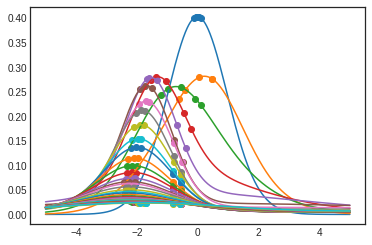

In [ ]:
K = 5
model = VGMM(K, nhidden_layers=2, hidden_size=128)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

#print(grad(model, training_inputs))

steps = 4000
for i in range(steps):
  """ 
  Hint: 
  grads = something with training_inputs...
  """
  grads = None  # TODO
  grads = grad(model, training_inputs)  # TODO

  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  if i % 100 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs)))
    plot_density(model.logits, model.means, model.lsigmas)

Compare to ground truth.

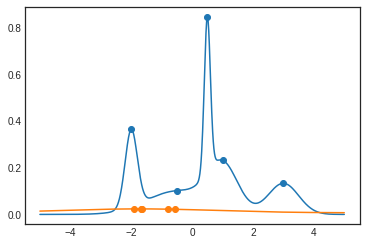

In [ ]:
plot_density(gt_logits, gt_means, gt_lsigmas)
plot_density(model.logits, model.means, model.lsigmas)

**Likelihood versus ELBO (6 Points)**

Recall that we can compute the exact likelihood for a GMM. Report the average difference between the true log likelihood and the ELBO on the training data.

In [ ]:
# TODO
LL_t = mixture_likelihood(training_inputs, gt_logits, gt_means, gt_lsigmas)

qt_logits = tf.random.normal(shape=[training_inputs.shape[0], gt_logits.shape[0]])
ELBO_t = elbo(training_inputs, qt_logits, gt_logits, gt_means, gt_lsigmas)
print(tf.reduce_mean(LL_t - ELBO_t))

print(kl_divergence(LL_t, ELBO_t))
print(kl_divergence(ELBO_t, LL_t))

tf.Tensor(0.6233239, shape=(), dtype=float32)
tf.Tensor(628.55664, shape=(), dtype=float32)
tf.Tensor(369.583, shape=(), dtype=float32)


**Matching Likelihood to ELBO (10 points)**

What is the missing piece to match the ELBO to log likelihood? Show the average difference between the true log likelihood and an adjusted ELBO that should match on the training data. *Hint the difference may not be exactly 0 due to numerical issues.*

In [ ]:
# TODO
#The missing part is the KL divergence between approximate posterior and  true posterior which is always greater or equal to zero.
#True posterior is intractable, there is no closed form solution for true posterior because of marginalizing over all latent z's.

true_posterior_p_logits = mixture_posterior_logits(training_inputs, gt_logits, gt_means, gt_lsigmas)
approximate_posterior_q_logits = mixture_posterior_logits(training_inputs, model.logits, model.means, model.lsigmas)

print(kl_divergence(true_posterior_p_logits, approximate_posterior_q_logits))




tf.Tensor([4.9709826 7.0955734 7.1186914 ... 0.6475284 4.135871  2.5729487], shape=(5000,), dtype=float32)


## Weighted KL VAE (30 Points)

Show that minimizing the loss
$$\sum_{i=1}^N \mathbb{E}_{z\sim q(\cdot \mid x_i)}\left[ \|x_i - \mu_{x|z}(z) \|^2 \right] + \beta\, \operatorname{KL}\left[q(z \mid x_i)\, ||\, p(z) \right]$$
is equivalent to maximizing the ELBO for some VAE. I.e. specificy the VAE model and how its loss leads to the loss above.

 **Answer:**

---


Here, the loss function of Variational Autoencoders is the sum of two components, with somehow contrasting effects: the reconstruction loss, improving the quality of the resulting images, and the Kullback-Leibler divergence, acting as a regularizer of the latent space. This is known as balancing problem. The generative loss (GL) is the summation of MSE (mean squared error or reconstruction loss) and KL term.

Total loss function for VAE is 
 GL = MSE + KL

 From Maximum Likelihood Estimate we know that maximizing the log likelihood
is equilvalent to minimizing the loss. That means if we minimize the above loss, we are actually maximizing the log likelihood indirectly. Further, we can write that,

log likelihood = ELBO + KL divergence between approximate posterior and true posterior

here , first term elbo is tractable but the second term is intractable because of the fact that true posterior is intractable. But we know that KL divengence is always positive;  it is atleast zero or greater than zero. By removing the equality we can write that,

log likelihood >=  ELBO (tight lower bound)

ELBO is the tight lower bound of the log likelihood. By maximizing the elbo we are actually indirectly maximizing the log likelihood. Indirectly maximizing the log likelihood means, we are minimizing the loss function which is the above-mentioned loss function.
